In [1]:
import json
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random
import pickle
import os
import numpy as np
import gc

In [2]:
f = open('lotto_america_winning_nums.json', 'r')
data = json.load(f)

In [3]:
df = pd.DataFrame(data).transpose()
df.head()

,main_numbers,star_number,multiplier
"Wed, Dec 11, 2024","[4, 14, 30, 45, 50]",4,2x
"Mon, Dec 9, 2024","[15, 24, 29, 38, 51]",3,3x
"Sat, Dec 7, 2024","[7, 14, 31, 44, 46]",8,5x
"Wed, Dec 4, 2024","[10, 13, 32, 42, 44]",9,4x
"Mon, Dec 2, 2024","[1, 20, 37, 39, 47]",4,2x


In [4]:
df2 = pd.DataFrame(df)
ball_list = ['Ball 1', 'Ball 2', 'Ball 3', 'Ball 4', 'Ball 5']
df2[ball_list] \
    = pd.DataFrame(df.main_numbers.tolist(), index = df2.index)
df2 = df2.drop('main_numbers', axis=1)
cols = []
cols.extend(ball_list)
cols.append('star_number')
cols.append('multiplier')
df2 = df2[cols]
df2.rename(columns={'star_number': 'All Star Ball', 'multiplier' : 'Multiplier'}, inplace=True)
df2.head()

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,All Star Ball,Multiplier
"Wed, Dec 11, 2024",4,14,30,45,50,4,2x
"Mon, Dec 9, 2024",15,24,29,38,51,3,3x
"Sat, Dec 7, 2024",7,14,31,44,46,8,5x
"Wed, Dec 4, 2024",10,13,32,42,44,9,4x
"Mon, Dec 2, 2024",1,20,37,39,47,4,2x


In [5]:
#Build a Law of Large Numbers Dataset to compare to
file_path = "synthetic_drawings.pickle"
lln_synthetic_draws = {}
#Anticipate needing ~ 32G of ram to run your usual stuff plus this
def generate_synthetic_draws(sample_draws=5000000):
    rng = np.random.default_rng()
    all_balls = range(1, 52 + 1)
    all_balls = np.array(all_balls, dtype=np.uint8) #Never enough RAM, I'm tempted to build some kind of dataloader
    allstar_balls = range(1, 10 + 1)
    allstar_balls = np.array(allstar_balls, dtype=np.uint8)
    lln_synthetic_draws = {}

    
    for i in np.array(range(sample_draws), dtype=np.uint32):
        drawing = np.sort(rng.choice(all_balls, size=5, replace=False))
        all_star = rng.choice(allstar_balls, size=1, replace=False)
        lln_synthetic_draws[i] = {"Balls" : drawing, "Allstar" : all_star}
    with open(file_path, 'wb') as f:
        pickle.dump(lln_synthetic_draws, f)
        f.flush()  # Ensure all data is written to disk 'fore we take out the trash
    lln_synthetic_draws.clear()
    gc.collect() #Seriously, never enough RAM
    print('Took out the garbage, sire')
    


if os.path.exists(file_path):
    with open(file_path, 'rb') as f:
        lln_synthetic_df = pd.DataFrame.from_dict(pickle.load(f), orient='index')
else:
    generate_synthetic_draws()
    with open(file_path, 'rb') as f:
        lln_synthetic_df = pd.DataFrame.from_dict(pickle.load(f), orient='index')
lln_synthetic_df.head()

Took out the garbage, sire


,Balls,Allstar
0,"[3, 5, 6, 32, 40]",[7]
1,"[3, 11, 14, 37, 48]",[4]
2,"[4, 37, 38, 40, 47]",[6]
3,"[2, 3, 9, 29, 52]",[2]
4,"[25, 35, 44, 46, 49]",[10]


In [6]:
# Calculate ball frequency from synthetic draws
synthetic_counts = pd.Series([ball for sublist in lln_synthetic_df['Balls'] for ball in sublist]).value_counts(normalize=True)
synthetic_counts = synthetic_counts.reset_index()
synthetic_counts.columns = ['Ball Number', 'Synthetic Frequency']
synthetic_counts['Synthetic Frequency'] = synthetic_counts['Synthetic Frequency'] * 100

# Calculate ball frequency from real draws
real_counts = df2[ball_list].values.flatten()
real_counts = pd.Series(real_counts).value_counts(normalize=True).reset_index()
real_counts.columns = ['Ball Number', 'Real Frequency']
real_counts['Real Frequency'] = real_counts['Real Frequency'] * 100

# Merge synthetic and real frequencies into one DataFrame
combined_counts = pd.merge(real_counts, synthetic_counts, on='Ball Number', how='outer').fillna(0)

# Melt the data for easier plotting
combined_counts = pd.melt(combined_counts, id_vars=['Ball Number'], 
                        value_vars=['Real Frequency', 'Synthetic Frequency'], 
                        var_name='Category', value_name='Frequency')

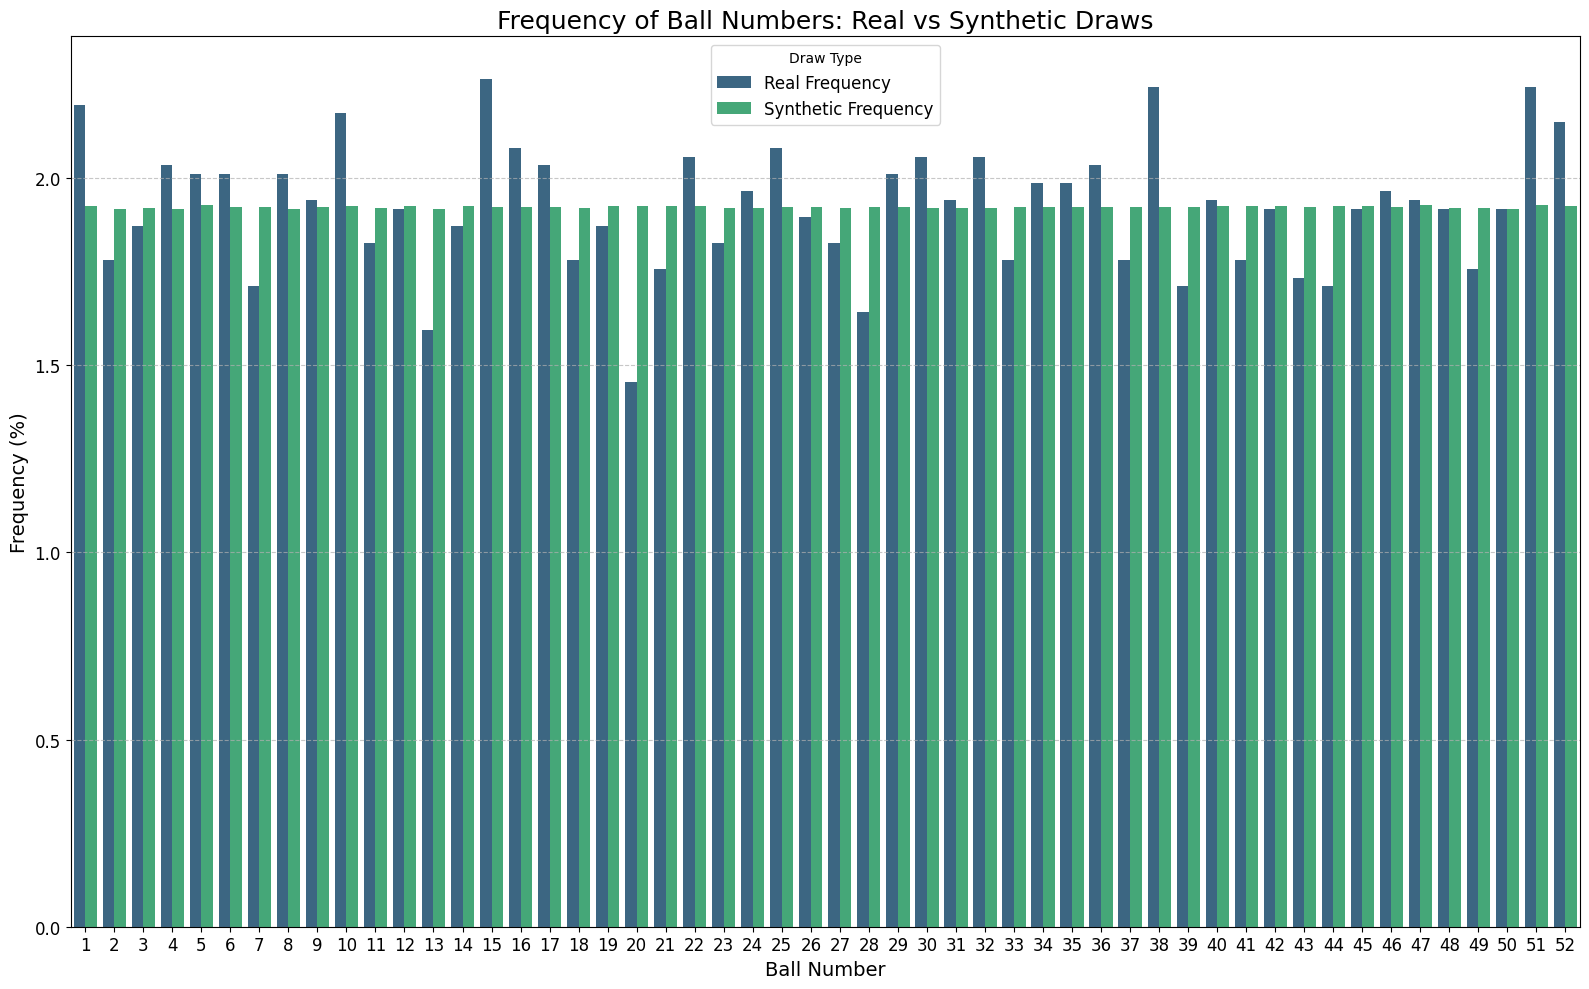

In [7]:
# Plot the data
plt.figure(figsize=(16, 10))
sns.barplot(data=combined_counts, x='Ball Number', y='Frequency', hue='Category', dodge=True, palette="viridis")
plt.title("Frequency of Ball Numbers: Real vs Synthetic Draws", fontsize=18)
plt.xlabel("Ball Number", fontsize=14)
plt.ylabel("Frequency (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Draw Type', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

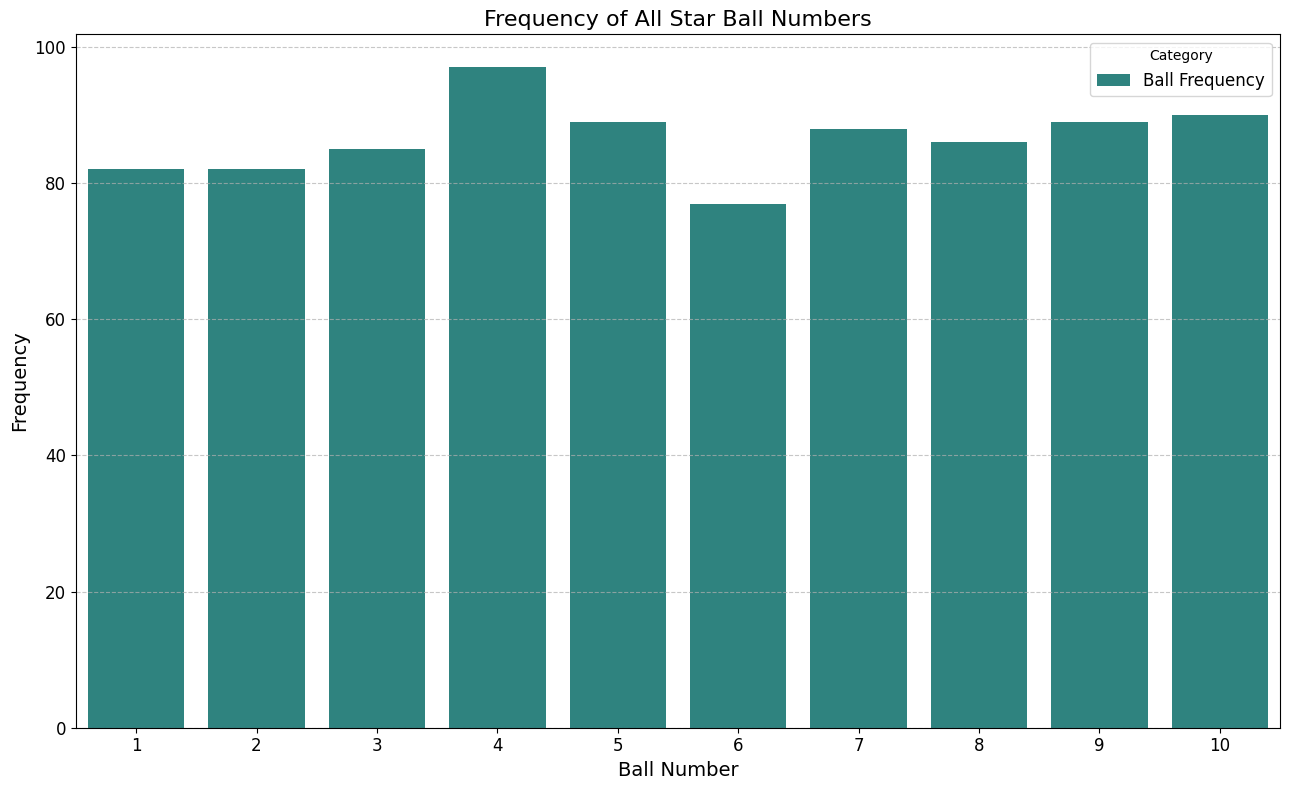

In [8]:
counts = df2['All Star Ball'].values
ball_counts = pd.Series(counts).value_counts().reset_index()
ball_counts.columns = ['Ball Number', 'Frequency']

# Create a new column for hue to categorize as "Ball Frequency"
ball_counts['Category'] = 'Ball Frequency'

# Create the plot
plt.figure(figsize=(13, 8))
sns.barplot(data=ball_counts, x='Ball Number', y='Frequency', hue='Category', dodge=False, palette="viridis")
plt.title("Frequency of All Star Ball Numbers", fontsize=16)
plt.xlabel("Ball Number", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Category', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
def count_even_odd(row):
    even_count = sum(num % 2 == 0 for num in row)
    odd_count = len(row) - even_count
    return pd.Series({"Even": even_count, "Odd": odd_count})


df_counts = df2[ball_list].apply(count_even_odd, axis=1)
df2['Even'] = df_counts['Even']
df2['Odd'] = df_counts['Odd']
df2.head()

,Ball 1,Ball 2,Ball 3,Ball 4,Ball 5,All Star Ball,Multiplier,Even,Odd
"Wed, Dec 11, 2024",4,14,30,45,50,4,2x,4,1
"Mon, Dec 9, 2024",15,24,29,38,51,3,3x,2,3
"Sat, Dec 7, 2024",7,14,31,44,46,8,5x,3,2
"Wed, Dec 4, 2024",10,13,32,42,44,9,4x,4,1
"Mon, Dec 2, 2024",1,20,37,39,47,4,2x,1,4


In [10]:
# Create a 'Distribution' column combining Odd and Even counts
df2["Distribution"] = df2.apply(lambda x: f"{int(x['Odd'])} Odd, {int(x['Even'])} Even", axis=1)
distribution_counts_real = df2["Distribution"].value_counts(normalize=True) * 100

distribution_df_real = distribution_counts_real.reset_index()
distribution_df_real.columns = ["Distribution", "Percentage"]
distribution_df_real['Category'] = 'Real Data'

# Process synthetic data for even/odd distribution (optimize for large data)
synthetic_counts = lln_synthetic_df['Balls'].apply(lambda row: count_even_odd(row))
lln_synthetic_df['Even'] = synthetic_counts['Even']
lln_synthetic_df['Odd'] = synthetic_counts['Odd']

# Create a 'Distribution' column combining Odd and Even counts for synthetic data
lln_synthetic_df["Distribution"] = lln_synthetic_df.apply(lambda x: f"{int(x['Odd'])} Odd, {int(x['Even'])} Even", axis=1)
distribution_counts_synthetic = lln_synthetic_df["Distribution"].value_counts(normalize=True) * 100

distribution_df_synthetic = distribution_counts_synthetic.reset_index()
distribution_df_synthetic.columns = ["Distribution", "Percentage"]
distribution_df_synthetic['Category'] = 'Synthetic Data'


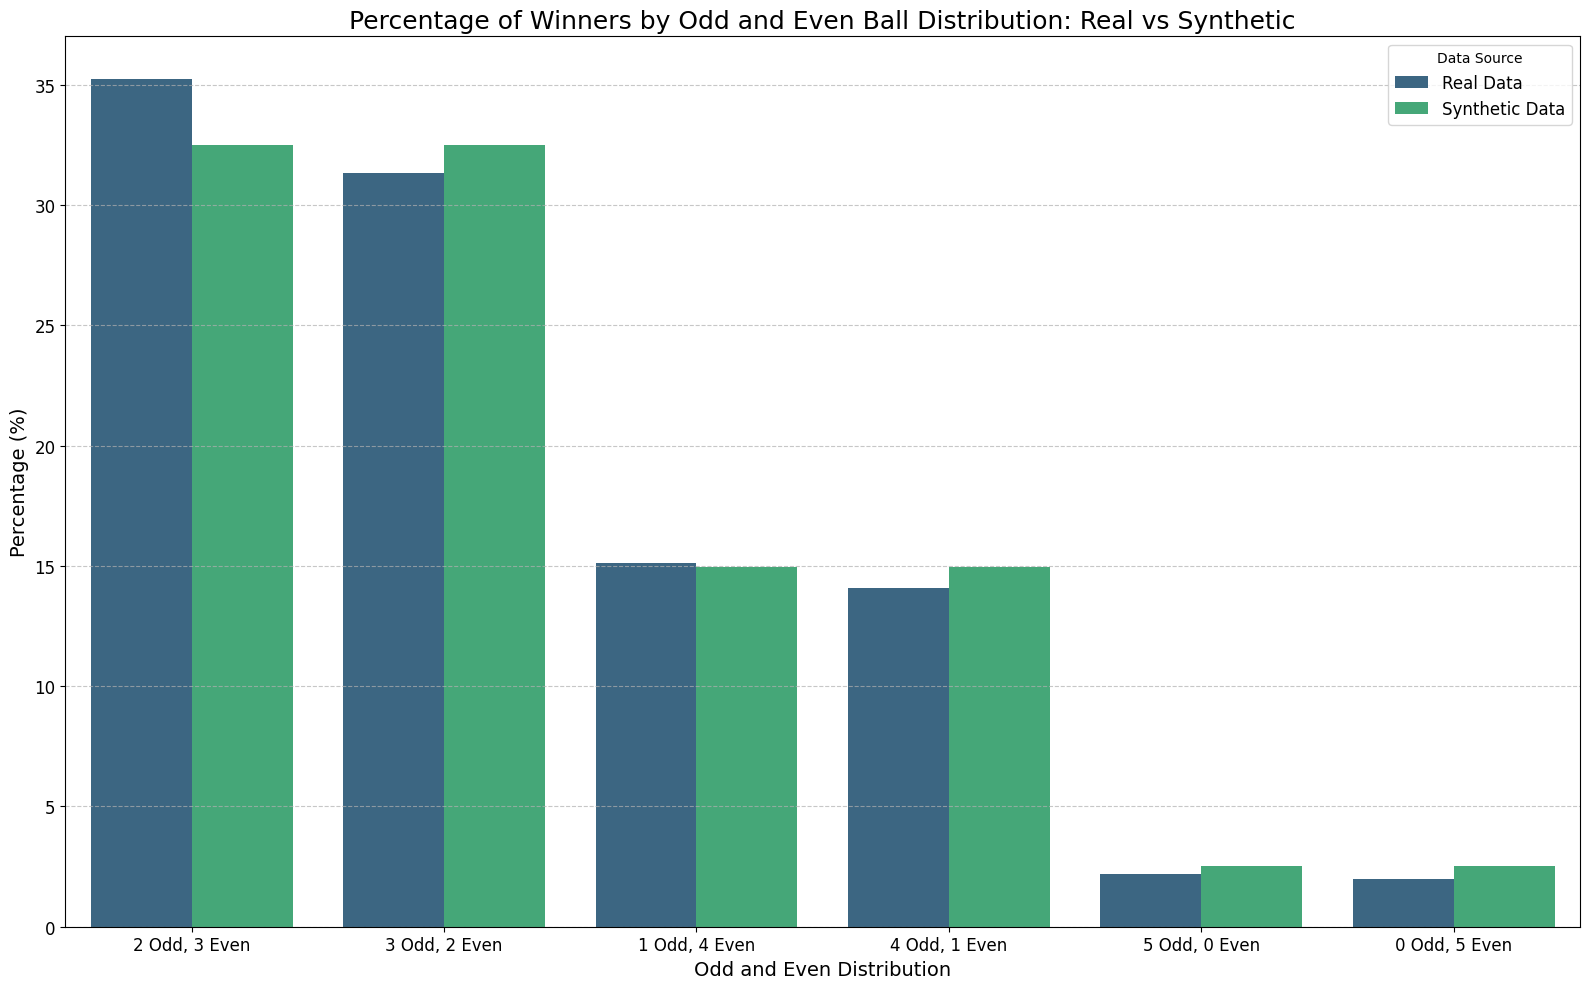

In [11]:
# Combine both distributions
distribution_combined = pd.concat([distribution_df_real, distribution_df_synthetic], ignore_index=True)

# Plot the results
plt.figure(figsize=(16, 10))
sns.barplot(data=distribution_combined, x="Distribution", y="Percentage", hue="Category", dodge=True, palette="viridis")
plt.title("Percentage of Winners by Odd and Even Ball Distribution: Real vs Synthetic", fontsize=18)
plt.xlabel("Odd and Even Distribution", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Data Source", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Compute all possible combinations of 5 balls, WIP
all_balls = range(1, 52 + 1)
combinations = itertools.combinations(all_balls, 5)
all_possible_sums = set([sum(comb) for comb in combinations])

In [13]:
def sum_balls(row):
    return sum(row)

df2['Sum'] = df2[ball_list].apply(sum_balls, axis=1)
frequency_dict_real = {s: 0 for s in all_possible_sums}

In [14]:
# Count occurrences of each sum in the real data
for sum_value in df2['Sum']:
    if sum_value in frequency_dict_real:
        frequency_dict_real[sum_value] += 1

In [15]:
# Convert frequencies to percentages for real data
real_total = sum(frequency_dict_real.values())
real_plot_data = pd.DataFrame({
    'Sum': list(frequency_dict_real.keys()),
    'Frequency': [freq / real_total * 100 for freq in frequency_dict_real.values()]
})
real_plot_data['Category'] = 'Real Data'

In [16]:
# Process synthetic data for total sums (optimized for large data)
lln_synthetic_df['Sum'] = lln_synthetic_df['Balls'].apply(sum_balls)
frequency_dict_synthetic = {s: 0 for s in all_possible_sums}

# Count occurrences of each sum in the synthetic data
for sum_value in lln_synthetic_df['Sum']:
    if sum_value in frequency_dict_synthetic:
        frequency_dict_synthetic[sum_value] += 1

# Convert frequencies to percentages for synthetic data
synthetic_total = sum(frequency_dict_synthetic.values())
synthetic_plot_data = pd.DataFrame({
    'Sum': list(frequency_dict_synthetic.keys()),
    'Frequency': [freq / synthetic_total * 100 for freq in frequency_dict_synthetic.values()]
})
synthetic_plot_data['Category'] = 'Synthetic Data'

In [17]:
# Combine both datasets
combined_plot_data = pd.concat([real_plot_data, synthetic_plot_data], ignore_index=True)

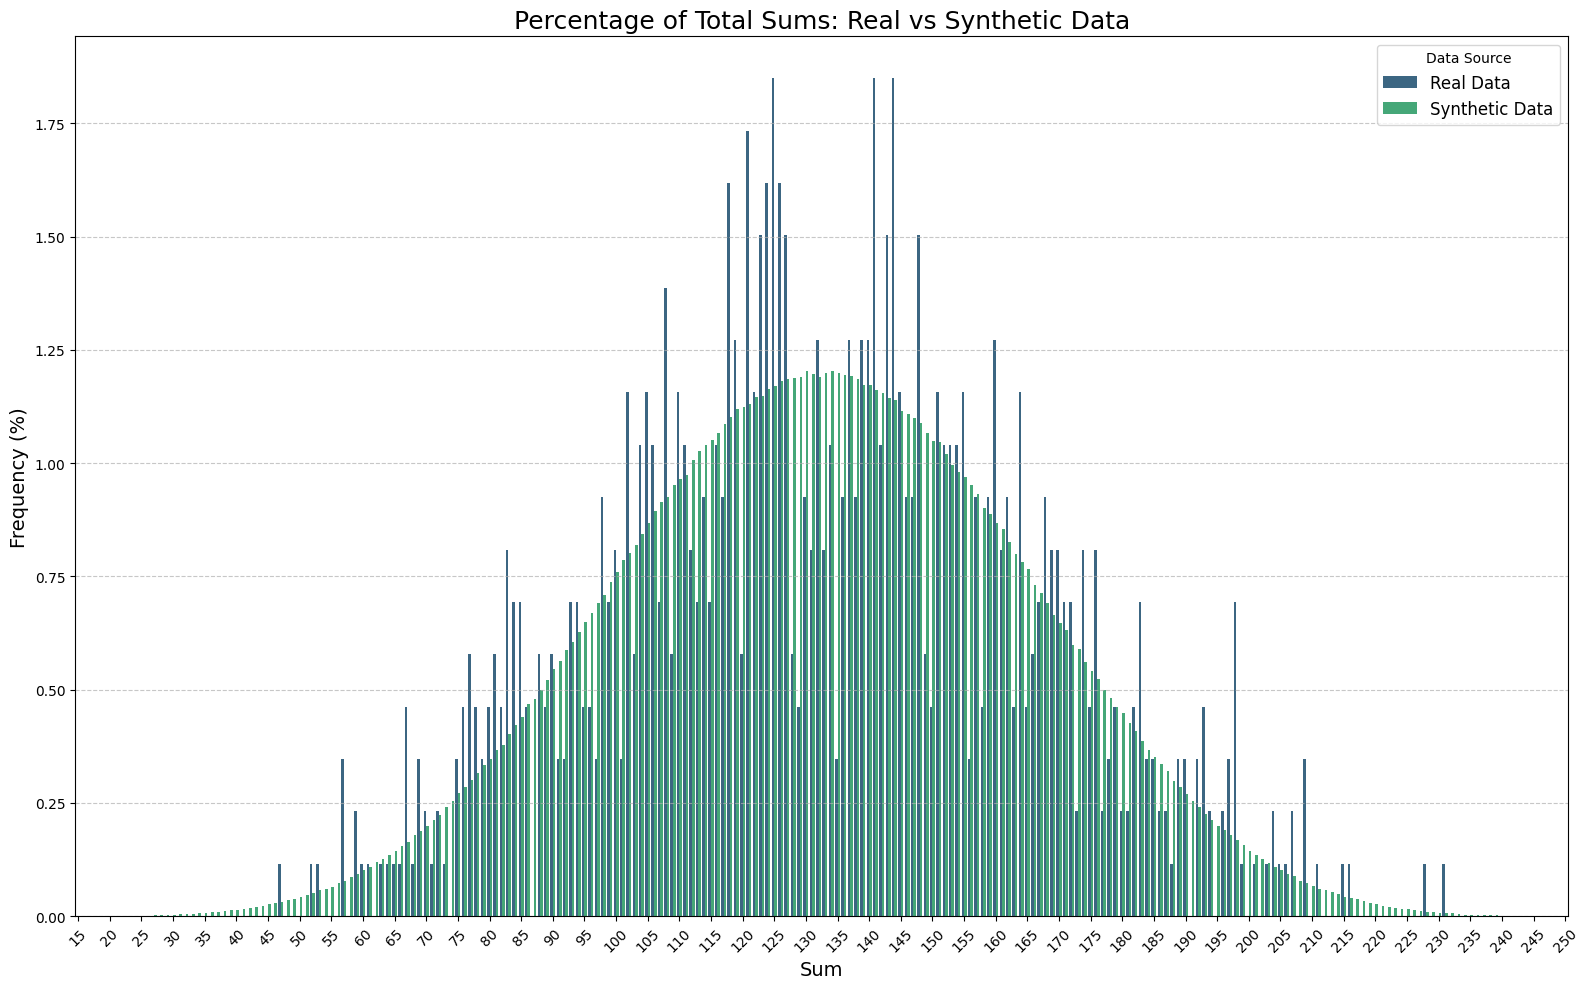

In [18]:
# Plot the data
plt.figure(figsize=(16, 10))
sns.barplot(data=combined_plot_data, x='Sum', y='Frequency', hue='Category', dodge=True, palette="viridis")
plt.title('Percentage of Total Sums: Real vs Synthetic Data', fontsize=18)
plt.xlabel('Sum', fontsize=14)
plt.ylabel('Frequency (%)', fontsize=14)
plt.xticks(ticks=range(0, len(combined_plot_data['Sum'].unique()), max(1, len(combined_plot_data['Sum'].unique()) // 40)), rotation=45)
plt.legend(title='Data Source', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()